In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import f1_score, precision_score, recall_score
import pickle
%matplotlib inline

In [2]:
df = pd.read_csv('rb_final1.csv')
df = df.drop(columns=['Unnamed: 0', '3 Cone', 'Shuttle', 'Vertical Jump', 'Position', 'PK', 'Year'])

In [3]:
df.tail()

,Round,Pick,Team,Player,Age,School,Weight,40 Time,Height (in),G,...,RecYds,RecAvg,RecTD,Plays,TotalYds,YardsPerPlay,TotalTDs,YPG,Conf,response
620,6,217,CHI,Khalil Herbert,23.0,Virginia Tech,210.0,4.46,68.0,11.0,...,179.0,17.900000,1.0,165.0,1362.0,8.254545,9.0,123.818182,ACC,3.0
621,7,233,LAR,Jake Funk,23.0,Maryland,204.0,4.49,70.0,5.0,...,68.0,6.800000,1.0,70.0,584.0,8.342857,4.0,116.800000,Big Ten,4.0
622,7,244,MIA,Gerrid Doaks,23.0,Cincinnati,NaN,NaN,NaN,30.0,...,407.0,11.305556,4.0,367.0,2119.0,5.773842,18.0,70.633333,American,4.0
623,7,256,GNB,Kylin Hill,23.0,Mississippi St.,214.0,4.51,70.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
624,7,257,DET,Jermar Jefferson,21.0,Oregon St.,206.0,4.57,70.0,27.0,...,299.0,6.953488,2.0,557.0,3222.0,5.784560,29.0,119.333333,Pac-12,4.0


In [4]:
df = df[(df['response'].notna()) & (df['RushYds'].notna())]
df.isna().sum()

Round            0
Pick             0
Team             0
Player           0
Age              1
School           0
Weight          38
40 Time         74
Height (in)     38
G                0
RushAtt          0
RushYds          0
RushAvg          0
RushTD           0
Rec              0
RecYds           0
RecAvg           0
RecTD            0
Plays            0
TotalYds         0
YardsPerPlay     0
TotalTDs         0
YPG              0
Conf             0
response         0
dtype: int64

In [5]:
df.shape

(406, 25)

In [6]:
# setting missing values
df = df.copy()
# df.loc[df['RushAvg'].isna(), 'RushAvg'] = 0
df.loc[df['Weight'].isna(), 'Weight'] = df['Weight'].median()
df.loc[df['40 Time'].isna(), '40 Time'] = df['40 Time'].median()
df.loc[df['Height (in)'].isna(), 'Height (in)'] = df['Height (in)'].median()

In [7]:
# removing outliers
df = df[(np.abs(stats.zscore(df['Rec'])) < 3)]
df = df[(np.abs(stats.zscore(df['RushYds'])) < 3)]
df = df[(np.abs(stats.zscore(df['RecYds'])) < 3)]
df = df[(np.abs(stats.zscore(df['RecTD'])) < 3)]
df = df[(np.abs(stats.zscore(df['TotalYds'])) < 3)]
df = df[(np.abs(stats.zscore(df['RushAtt'])) < 3)]
df = df[(np.abs(stats.zscore(df['RushTD'])) < 3)]
df.shape

(376, 25)

In [8]:
# seperating features and response and removing player name
response = df['response']
df = df.drop(columns = ['Player'])

In [9]:
# seperating data into numeric and categorical columns
df_cat = df[['Team', 'School', 'Conf']].copy()
df_num = df.drop(columns = ['Team', 'School', 'Conf']).copy()

In [10]:
# checking for high correlations with response variable
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(df_num.corr())

                 Round      Pick       Age    Weight   40 Time  Height (in)  \
Round         1.000000  0.985265  0.256669 -0.139820  0.282882    -0.135180   
Pick          0.985265  1.000000  0.260917 -0.140661  0.271681    -0.137733   
Age           0.256669  0.260917  1.000000 -0.044500  0.096362     0.066793   
Weight       -0.139820 -0.140661 -0.044500  1.000000  0.264196     0.622166   
40 Time       0.282882  0.271681  0.096362  0.264196  1.000000     0.092209   
Height (in)  -0.135180 -0.137733  0.066793  0.622166  0.092209     1.000000   
G            -0.059140 -0.066676 -0.086906  0.037617  0.009661    -0.065681   
RushAtt      -0.191208 -0.203621 -0.179982  0.033464  0.036808    -0.063201   
RushYds      -0.250138 -0.255287 -0.233125 -0.013986 -0.035602    -0.109346   
RushAvg      -0.176557 -0.154721 -0.172499 -0.124804 -0.200882    -0.128855   
RushTD       -0.258597 -0.263701 -0.218511  0.102662 -0.019929     0.007952   
Rec          -0.097460 -0.106147 -0.138267 -0.201385

(array([ 64.,  83., 175.,  54.]),
 array([1.  , 1.75, 2.5 , 3.25, 4.  ]),
 <BarContainer object of 4 artists>)

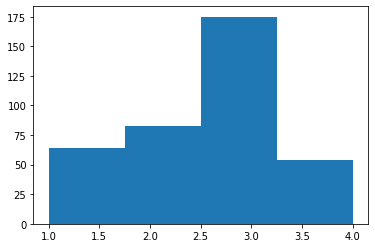

In [11]:
plt.hist(df['response'], bins=4)

In [12]:
# creating training and testing data for catboost model
X_train_cb, X_test_cb, y_train_cb, y_test_cb = train_test_split(df.drop(columns='response'), response, test_size=.2)

In [13]:
# initiating model
cat_model = CatBoostClassifier()

# using grid search to determine best parameters
grid = {'iterations': [1, 2, 3, 4, 5],
        'depth': [1, 2, 4, 6, 10],
        'learning_rate': [.3, .7, 1]}

# Pooling data before fitting
pool_train = Pool(X_train_cb, y_train_cb, cat_features=['Team', 'School', 'Conf'])

gs_result = cat_model.grid_search(grid, pool_train)

0:	learn: 1.3163393	test: 1.3464943	best: 1.3464943 (0)	total: 159ms	remaining: 0us

bestTest = 1.346494334
bestIteration = 0

0:	loss: 1.3464943	best: 1.3464943 (0)	total: 191ms	remaining: 14.1s
0:	learn: 1.2615090	test: 1.3318708	best: 1.3318708 (0)	total: 681us	remaining: 0us

bestTest = 1.331870818
bestIteration = 0

1:	loss: 1.3318708	best: 1.3318708 (1)	total: 193ms	remaining: 7.05s
0:	learn: 1.2509119	test: 1.3514288	best: 1.3514288 (0)	total: 566us	remaining: 0us

bestTest = 1.351428832
bestIteration = 0

2:	loss: 1.3514288	best: 1.3318708 (1)	total: 195ms	remaining: 4.68s
0:	learn: 1.3163393	test: 1.3464943	best: 1.3464943 (0)	total: 561us	remaining: 561us
1:	learn: 1.2600453	test: 1.3017679	best: 1.3017679 (1)	total: 5.54ms	remaining: 0us

bestTest = 1.301767923
bestIteration = 1

3:	loss: 1.3017679	best: 1.3017679 (3)	total: 202ms	remaining: 3.58s
0:	learn: 1.2615090	test: 1.3318708	best: 1.3318708 (0)	total: 964us	remaining: 964us
1:	learn: 1.1861416	test: 1.2487198	best: 1

In [14]:
# pooling test data
pool_test = Pool(X_test_cb, y_test_cb, cat_features=['Team', 'School', 'Conf'])

# making predictions
cat_preds = cat_model.predict(pool_test)
cat_proba = cat_model.predict_proba(pool_test)

In [15]:
display(f1_score(y_test_cb, cat_preds, average='macro'))

0.39196310935441375

In [16]:
# saving the initial model to a pkl file
rb_pickled_initial = pickle.dump(cat_model, open('rb_pickled_initial.pkl', 'wb'))

In [17]:
cat_proba[0][0]

0.09407385938571952

In [18]:
pd.DataFrame({
        "Chance of being a superstar": [cat_proba[0][0]],
        "Chance of being a star": [cat_proba[0][1]],
        "Chance of being a contributor": [cat_proba[0][2]],
        "Chance of being a dud": [cat_proba[0][3]]
    })

,Chance of being a superstar,Chance of being a star,Chance of being a contributor,Chance of being a dud
0,0.094074,0.124472,0.743577,0.037877
